# Observables

In [1]:
import os
import warnings
import dill
import matplotlib
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.core.display import Markdown
from qiskit.providers import Backend
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler
from squlearn import Executor
from squlearn.encoding_circuit import YZ_CX_EncodingCircuit, RandomLayeredEncodingCircuit
from squlearn.observables import SummedPaulis, SummedProbabilities, IsingHamiltonian, CustomObservable
from squlearn.optimizers import Adam
from squlearn.qnn import QNNClassifier, CrossEntropyLoss
from observables import SummedNeighbours, SummedPairs, SummedSingles
from utils.encoding_circuits import get_measurement_circuits, plot_encoded_quantum_data
from utils.observables import get_pauli_sum, get_pauli_strings
from utils.pareto_plot import pareto_plot

In [2]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline

In [3]:
warnings.filterwarnings("ignore")

In [4]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42, stratify=y)

In [5]:
encoding_circuit = RandomLayeredEncodingCircuit(num_qubits=5, num_features=5, min_num_layers=3, max_num_layers=3, seed=12_08_1887)
num_qubits = encoding_circuit.num_qubits

### Summed Paulis

In [6]:
display(Markdown("<br>".join(get_pauli_sum(observable) for observable in [
    SummedPaulis(num_qubits=num_qubits, op_str="X"),
    SummedPaulis(num_qubits=num_qubits, op_str="Y"),
    SummedPaulis(num_qubits=num_qubits, op_str="Z"),
    SummedPaulis(num_qubits=num_qubits, op_str=("X", "Y")),
    SummedPaulis(num_qubits=num_qubits, op_str=("X", "Z")),
    SummedPaulis(num_qubits=num_qubits, op_str=("Y", "Z")),
    SummedPaulis(num_qubits=num_qubits, op_str=("X", "Y", "Z"))
])))

IIIII + IIIIX + IIIXI + IIXII + IXIII + XIIII<br>IIIII + IIIIY + IIIYI + IIYII + IYIII + YIIII<br>IIIII + IIIIZ + IIIZI + IIZII + IZIII + ZIIII<br>IIIII + IIIIX + IIIXI + IIXII + IXIII + XIIII + IIIIY + IIIYI + IIYII + IYIII + YIIII<br>IIIII + IIIIX + IIIXI + IIXII + IXIII + XIIII + IIIIZ + IIIZI + IIZII + IZIII + ZIIII<br>IIIII + IIIIY + IIIYI + IIYII + IYIII + YIIII + IIIIZ + IIIZI + IIZII + IZIII + ZIIII<br>IIIII + IIIIX + IIIXI + IIXII + IXIII + XIIII + IIIIY + IIIYI + IIYII + IYIII + YIIII + IIIIZ + IIIZI + IIZII + IZIII + ZIIII

### Summed Probabilities

In [7]:
display(Markdown(get_pauli_sum(SummedProbabilities(num_qubits=num_qubits))))

IIIII + IIIII + IIIIZ + IIIII + IIIZI + IIIII + IIZII + IIIII + IZIII + IIIII + ZIIII

### Ising Hamiltonian

In [8]:
display(Markdown(get_pauli_sum(IsingHamiltonian(num_qubits=num_qubits))))

IIIII + IIIIZ + IIIZI + IIZII + IZIII + ZIIII + IIIZZ + IIZIZ + IIZZI + IZIIZ + IZIZI + IZZII + ZIIIZ + ZIIZI + ZIZII + ZZIII

### Summed Singles

In [9]:
display(Markdown("<br>".join(get_pauli_sum(observable) for observable in [
    SummedSingles(num_qubits=num_qubits, bases=["X", "Y", "Z"], seed=23_04_1858),  # Planck
    SummedSingles(num_qubits=num_qubits, bases=["X", "Y", "Z"], seed=14_03_1879),  # Einstein
    SummedSingles(num_qubits=num_qubits, bases=["X", "Y", "Z"], seed=12_08_1887),  # Schrödinger
    SummedSingles(num_qubits=num_qubits, bases=["X", "Y", "Z"], seed=25_04_1900),  # Pauli
    SummedSingles(num_qubits=num_qubits, bases=["X", "Y", "Z"], seed=5_12_1901),  # Heisenberg
])))

XIIII + IZIII + IIYII + IIIYI + IIIIY + IIIII<br>ZIIII + IZIII + IIXII + IIIYI + IIIIY + IIIII<br>YIIII + IZIII + IIXII + IIIYI + IIIIZ + IIIII<br>ZIIII + IZIII + IIYII + IIIZI + IIIIY + IIIII<br>ZIIII + IYIII + IIXII + IIIYI + IIIIY + IIIII

### Summed Neighbours

In [10]:
display(Markdown("<br>".join(get_pauli_sum(observable) for observable in [
    SummedNeighbours(num_qubits=num_qubits, bases=["X"]),
    SummedNeighbours(num_qubits=num_qubits, bases=["Y"]),
    SummedNeighbours(num_qubits=num_qubits, bases=["Z"]),
    SummedNeighbours(num_qubits=num_qubits, bases=["X", "Y", "Z"], seed=23_04_1858),  # Planck
    SummedNeighbours(num_qubits=num_qubits, bases=["X", "Y", "Z"], seed=14_03_1879),  # Einstein
    SummedNeighbours(num_qubits=num_qubits, bases=["X", "Y", "Z"], seed=12_08_1887),  # Schrödinger
    SummedNeighbours(num_qubits=num_qubits, bases=["X", "Y", "Z"], seed=25_04_1900),  # Pauli
    SummedNeighbours(num_qubits=num_qubits, bases=["X", "Y", "Z"], seed=5_12_1901),  # Heisenberg
])))

XXIII + IXXII + IIXXI + IIIXX + IIIII<br>YYIII + IYYII + IIYYI + IIIYY + IIIII<br>ZZIII + IZZII + IIZZI + IIIZZ + IIIII<br>XZIII + IYYII + IIYZI + IIIZX + IIIII<br>ZZIII + IXYII + IIYYI + IIIXX + IIIII<br>YZIII + IXYII + IIZZI + IIIXX + IIIII<br>ZZIII + IYZII + IIYYI + IIIZX + IIIII<br>ZYIII + IXYII + IIYZI + IIIYZ + IIIII

### Summed Pairs

In [11]:
display(Markdown("<br>".join(get_pauli_sum(observable) for observable in [
    SummedPairs(num_qubits=num_qubits, bases=["X"]),
    SummedPairs(num_qubits=num_qubits, bases=["Y"]),
    SummedPairs(num_qubits=num_qubits, bases=["Z"]),
    SummedPairs(num_qubits=num_qubits, bases=["X", "Y", "Z"], seed=23_04_1858),  # Planck
    SummedPairs(num_qubits=num_qubits, bases=["X", "Y", "Z"], seed=14_03_1879),  # Einstein
    SummedPairs(num_qubits=num_qubits, bases=["X", "Y", "Z"], seed=12_08_1887),  # Schrödinger
    SummedPairs(num_qubits=num_qubits, bases=["X", "Y", "Z"], seed=25_04_1900),  # Pauli
    SummedPairs(num_qubits=num_qubits, bases=["X", "Y", "Z"], seed=5_12_1901),  # Heisenberg
])))

XXIII + XIXII + XIIXI + XIIIX + IXXII + IXIXI + IXIIX + IIXXI + IIXIX + IIIXX + IIIII<br>YYIII + YIYII + YIIYI + YIIIY + IYYII + IYIYI + IYIIY + IIYYI + IIYIY + IIIYY + IIIII<br>ZZIII + ZIZII + ZIIZI + ZIIIZ + IZZII + IZIZI + IZIIZ + IIZZI + IIZIZ + IIIZZ + IIIII<br>XZIII + YIYII + YIIZI + ZIIIX + IZYII + IYIYI + IYIIY + IIZZI + IIYIZ + IIIXZ + IIIII<br>ZZIII + XIYII + YIIYI + XIIIX + IXXII + IYIXI + IYIIY + IIXXI + IIXIY + IIIYY + IIIII<br>YZIII + XIYII + ZIIZI + XIIIX + IZXII + IXIXI + IZIIZ + IIYYI + IIYIY + IIIYX + IIIII<br>ZZIII + YIZII + YIIYI + ZIIIX + IZYII + IXIXI + IZIIY + IIXYI + IIYIY + IIIXY + IIIII<br>ZYIII + XIYII + YIIZI + YIIIZ + IYZII + IXIZI + IZIIZ + IIYXI + IIXIZ + IIIYY + IIIII

### Add Measurements to the Encoding Circuit

To evaluate a given observable, the encoding circuit must be extended with specific measurement gates. Since we can only measure the $Z$ basis, we must apply a basis transformation before the measurement occurs:

$\langle \psi | X | \psi \rangle = \langle \psi | H Z H | \psi \rangle$

$\langle \psi | Y | \psi \rangle =  \langle \psi | S H Z H S^\dagger | \psi \rangle$

$\langle \psi | Z | \psi \rangle = \langle \psi | Z | \psi \rangle$

These extra gates need to be taken into account when evaluating the encoding circuit and observable to use. Also, since a qubit cannot be measured in multiple bases simultaneously, observables with differing basis requirements must be evaluated through separate circuit executions, which is even more increasing the amount of gates required. The following example will illustrate this:

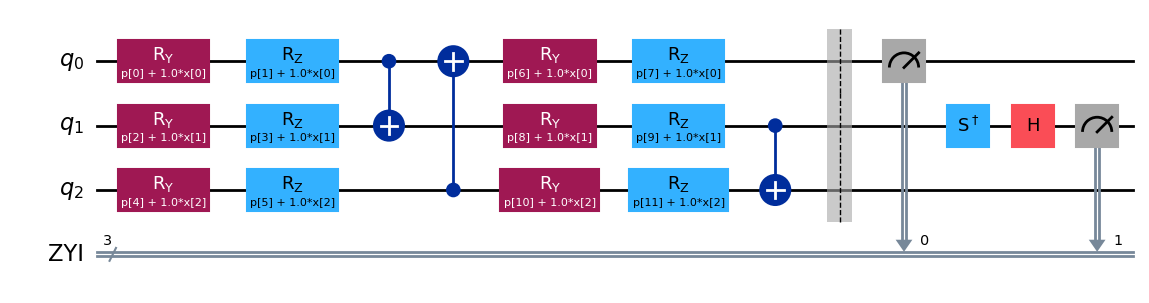

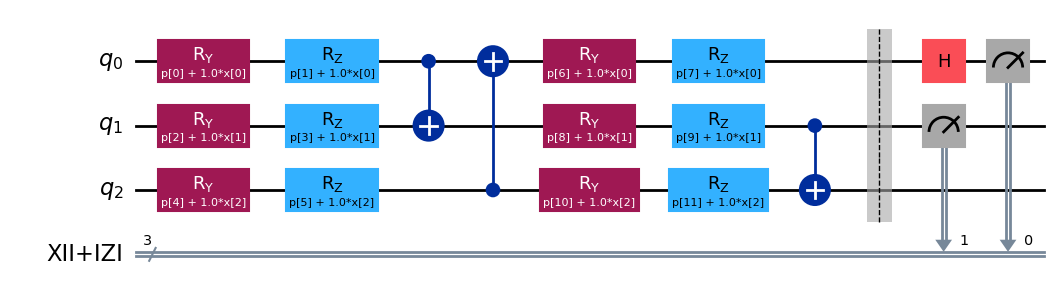

In [12]:
for measurement_circuit in get_measurement_circuits(
        encoding_circuit=YZ_CX_EncodingCircuit(num_qubits=3, num_features=3, num_layers=2),
        observable=CustomObservable(num_qubits=3, operator_string=["XII", "IZI", "ZYI"]),
):
    measurement_circuit.draw("mpl")

The measurements required for the observable $XII + IZI + ZYI$ are executed in two different circuits.

### Preselection of Observables

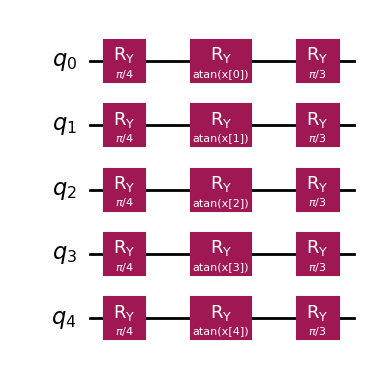

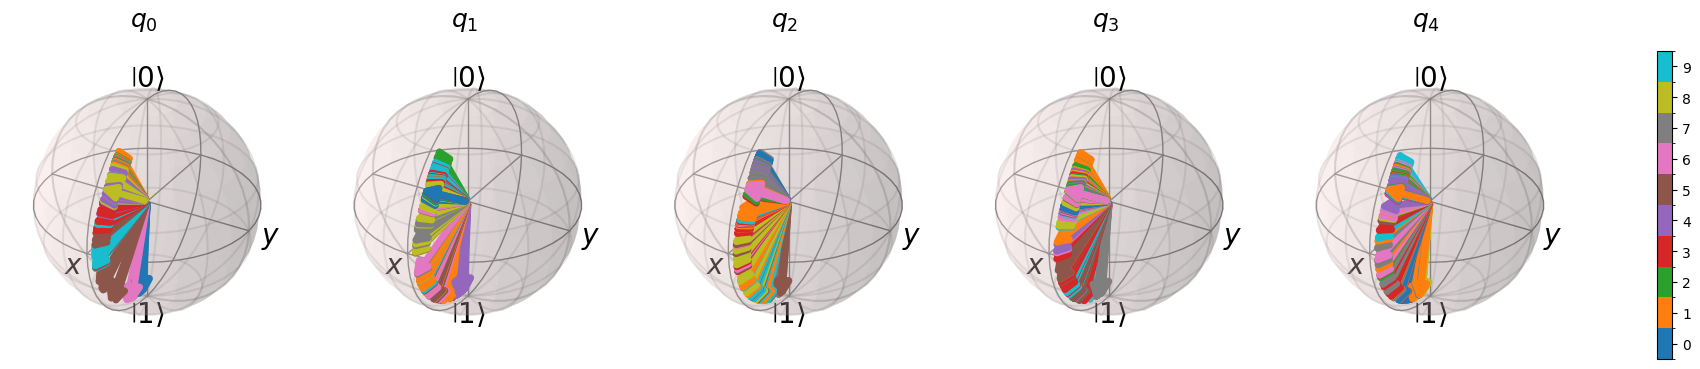

In [13]:
X_train_scaled = make_pipeline(
    Isomap(n_components=5),
    MinMaxScaler(feature_range=tuple(encoding_circuit.feature_bounds), clip=True),
).fit_transform(X_train)
encoding_circuit.draw("mpl")
plot_encoded_quantum_data(encoding_circuit, X_train_scaled[:100], y_train[:100])

The encoding circuit chosen in the previous notebook consists only of $R_Y$ gates, meaning the feature vector $\vec{x}$ is encoded only within the $XZ$ plane of the Bloch sphere. Consequently, an observable exclusively measuring in the $Y$ basis would result in a model incapable of learning. Let's verify this assumption:

In [14]:
num_classes = len(np.unique(y))
num_qubits = encoding_circuit.num_qubits

checkpoint_filename = "checkpoints/trained_models/measure_y_model.dill"

if os.path.isfile(checkpoint_filename):
    pipeline = dill.load(open(checkpoint_filename, "rb"))
else:
    pipeline = make_pipeline(
        Isomap(n_components=5, max_iter=10_000),
        MinMaxScaler(feature_range=tuple(encoding_circuit.feature_bounds), clip=True),
        QNNClassifier(
            encoding_circuit=encoding_circuit,
            operator=num_classes * [SummedPaulis(num_qubits=num_qubits, op_str="Y")],
            executor=Executor("qulacs"),
            loss=CrossEntropyLoss(),
            optimizer=Adam(),
        )
    )
    pipeline.fit(X_train, y_train)
    dill.dump(pipeline, open(checkpoint_filename, "wb"))

print(f"Random Guessing: {1 / num_classes:.4f}")
print(f"Train Accuracy:  {pipeline.score(X_train, y_train):.4f}")
print(f"Test Accuracy:   {pipeline.score(X_test, y_test):.4f}")

Random Guessing: 0.1000
Train Accuracy:  0.1016
Test Accuracy:   0.1000


Based on these results, we can conclude that the model is underfitting and has failed to learn any meaningful patterns. Therefore, we should restrict our hyperparameter search to observables measuring in the $X$ and $Z$ bases.

### Hyperparameter Search

In [15]:
num_classes = len(np.unique(y))
num_qubits = encoding_circuit.num_qubits
for filename, operators in {
    "summedpaulis": [
        num_classes * [SummedPaulis(num_qubits=num_qubits, op_str="X")],
        num_classes * [SummedPaulis(num_qubits=num_qubits, op_str="Z")],
        num_classes * [SummedPaulis(num_qubits=num_qubits, op_str=("X", "Z"))],
    ],
    "summedprobabilities": [
        num_classes * [SummedProbabilities(num_qubits=num_qubits)]
    ],
    "isinghamiltonian": [
        num_classes * [IsingHamiltonian(num_qubits=num_qubits)]
    ],
    "summedsingles": [
        num_classes * [SummedSingles(num_qubits=num_qubits, bases=["X", "Z"], seed=23_04_1858)],  # Planck
        num_classes * [SummedSingles(num_qubits=num_qubits, bases=["X", "Z"], seed=14_03_1879)],  # Einstein
        num_classes * [SummedSingles(num_qubits=num_qubits, bases=["X", "Z"], seed=12_08_1887)],  # Schrödinger
        num_classes * [SummedSingles(num_qubits=num_qubits, bases=["X", "Z"], seed=25_04_1900)],  # Pauli
        num_classes * [SummedSingles(num_qubits=num_qubits, bases=["X", "Z"], seed=5_12_1901)],  # Heisenberg
    ],
    "summedneighbours": [
        num_classes * [SummedNeighbours(num_qubits=num_qubits, bases=["X"])],
        num_classes * [SummedNeighbours(num_qubits=num_qubits, bases=["Z"])],
        num_classes * [SummedNeighbours(num_qubits=num_qubits, bases=["X", "Z"], seed=23_04_1858)],  # Planck
        num_classes * [SummedNeighbours(num_qubits=num_qubits, bases=["X", "Z"], seed=14_03_1879)],  # Einstein
        num_classes * [SummedNeighbours(num_qubits=num_qubits, bases=["X", "Z"], seed=12_08_1887)],  # Schrödinger
        num_classes * [SummedNeighbours(num_qubits=num_qubits, bases=["X", "Z"], seed=25_04_1900)],  # Pauli
        num_classes * [SummedNeighbours(num_qubits=num_qubits, bases=["X", "Z"], seed=5_12_1901)],  # Heisenberg
    ],
    "summedpairs": [
        num_classes * [SummedPairs(num_qubits=num_qubits, bases=["X"])],
        num_classes * [SummedPairs(num_qubits=num_qubits, bases=["Z"])],
        num_classes * [SummedPairs(num_qubits=num_qubits, bases=["X", "Z"], seed=23_04_1858)],  # Planck
        num_classes * [SummedPairs(num_qubits=num_qubits, bases=["X", "Z"], seed=14_03_1879)],  # Einstein
        num_classes * [SummedPairs(num_qubits=num_qubits, bases=["X", "Z"], seed=12_08_1887)],  # Schrödinger
        num_classes * [SummedPairs(num_qubits=num_qubits, bases=["X", "Z"], seed=25_04_1900)],  # Pauli
        num_classes * [SummedPairs(num_qubits=num_qubits, bases=["X", "Z"], seed=5_12_1901)],  # Heisenberg
    ]
}.items():
    checkpoint_filename = f"checkpoints/observables_optimal/{filename}.csv"
    if os.path.isfile(checkpoint_filename):
        continue
    grid_search = GridSearchCV(
        estimator=Pipeline([
            ("feature_reduction", Isomap(n_components=5, max_iter=10_000)),
            ("feature_scaling", MinMaxScaler(tuple(encoding_circuit.feature_bounds), clip=True)),
            ("classifier", QNNClassifier(
                encoding_circuit=encoding_circuit,
                operator=num_classes * [SummedPaulis(num_qubits=encoding_circuit.num_qubits)],
                executor=Executor("qulacs"),
                loss=CrossEntropyLoss(),
                optimizer=Adam(),
            )),
        ]),
        param_grid={
            "classifier__operator": operators,
        },
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring="accuracy",
        n_jobs=-1,
    )
    grid_search.fit(X_train, y_train)
    checkpoint_df = pd.DataFrame(grid_search.cv_results_)[[
        "param_classifier__operator",
        "mean_test_score",
    ]].rename(columns={
        "param_classifier__operator": "observable",
        "mean_test_score": "accuracy",
    })
    checkpoint_df["observable"] = checkpoint_df["observable"].apply(lambda x: get_pauli_strings(x[0]))
    checkpoint_df.to_csv(checkpoint_filename, index=False)

### Evaluation

In [16]:
def get_num_gates_by_row(row: pd.Series, backend: Backend | None) -> int:
    operator_string = [s.strip("'") for s in row["observable"].strip("[]").split(", ")]
    observable = CustomObservable(num_qubits=len(operator_string[0]), operator_string=operator_string)
    measurement_circuits = get_measurement_circuits(encoding_circuit, observable, backend)
    return sum(measurement_circuit.size() for measurement_circuit in measurement_circuits)


def get_label_by_row(row: pd.Series) -> str:
    operator_string = [s.strip("'") for s in row["observable"].strip("[]").split(", ")]
    observable = CustomObservable(num_qubits=len(operator_string[0]), operator_string=operator_string)
    return get_pauli_sum(observable)


def plot_gates_vs_accuracy(results: pd.DataFrame, backend: Backend | None) -> None:
    results["num_gates"] = results.apply(lambda row: get_num_gates_by_row(row, backend), axis=1)
    title = backend.__class__.__name__ if backend else "Simulator"
    pareto_plot(data=results, x="num_gates", y="accuracy", label=get_label_by_row, title=title)

In [17]:
path = Path("checkpoints/observables_optimal")
results = pd.concat([pd.read_csv(filename) for filename in path.glob("*.csv")], ignore_index=True)

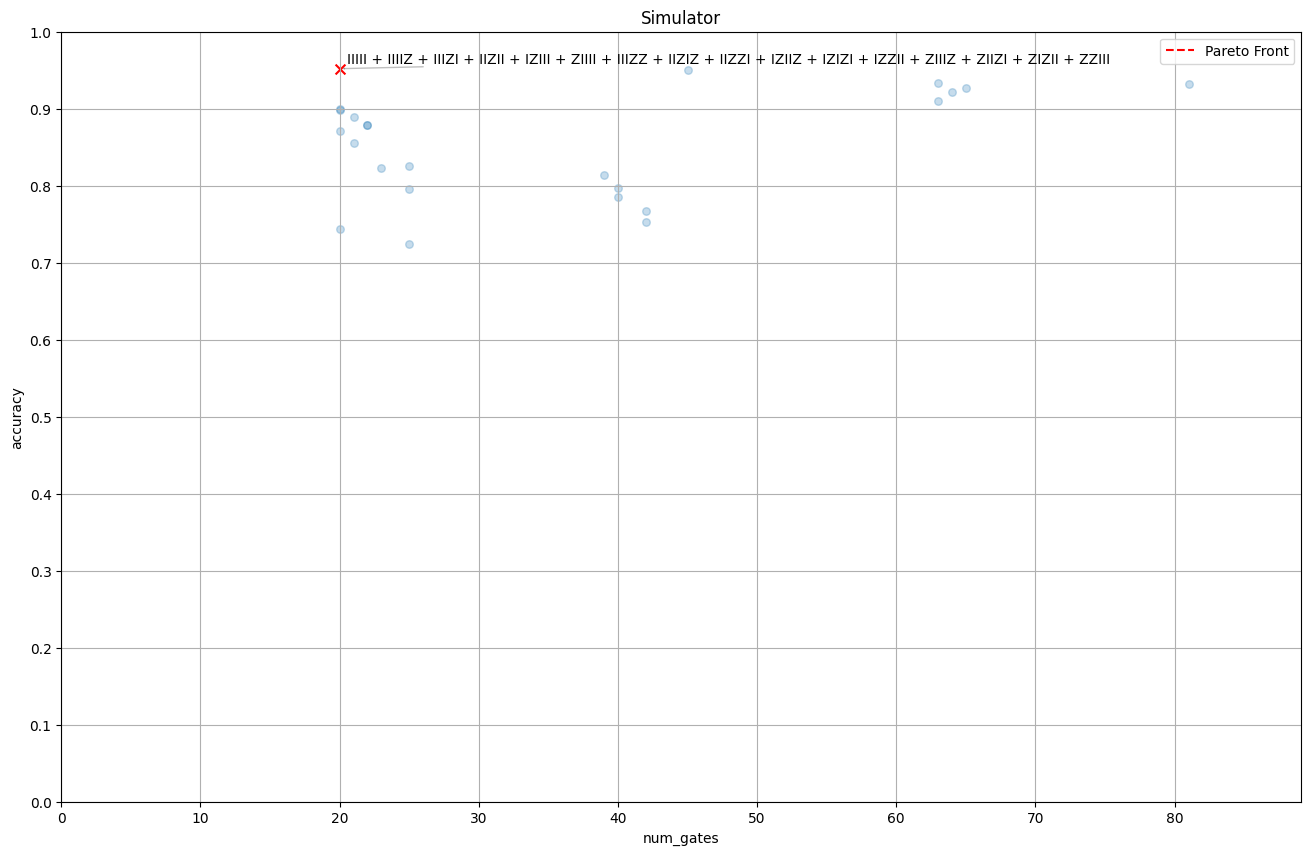

In [18]:
plot_gates_vs_accuracy(results, backend=None)

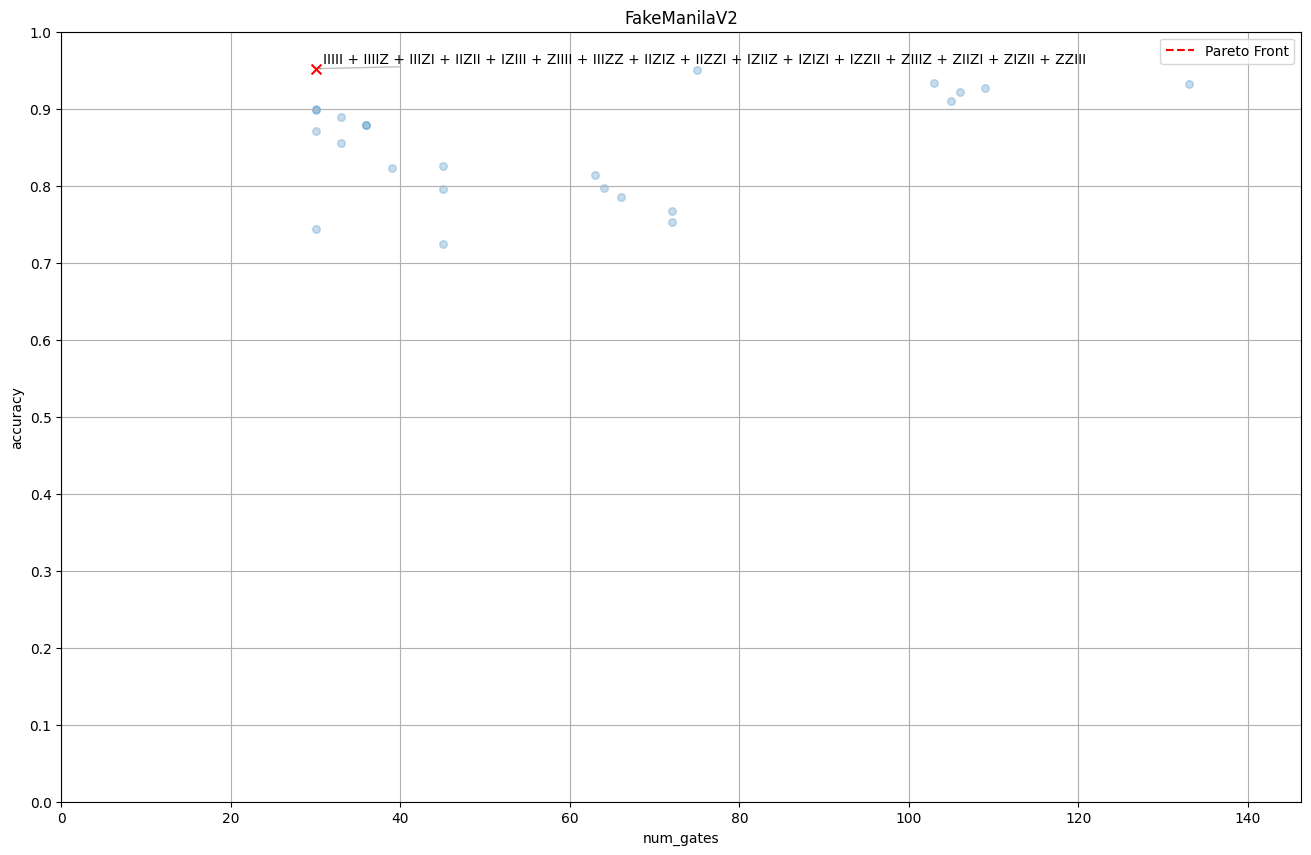

In [19]:
plot_gates_vs_accuracy(results, backend=FakeManilaV2())

### Decision

The `IsingHamiltonian` is the only pareto-optimal point in the plot, and therefore we will select it.

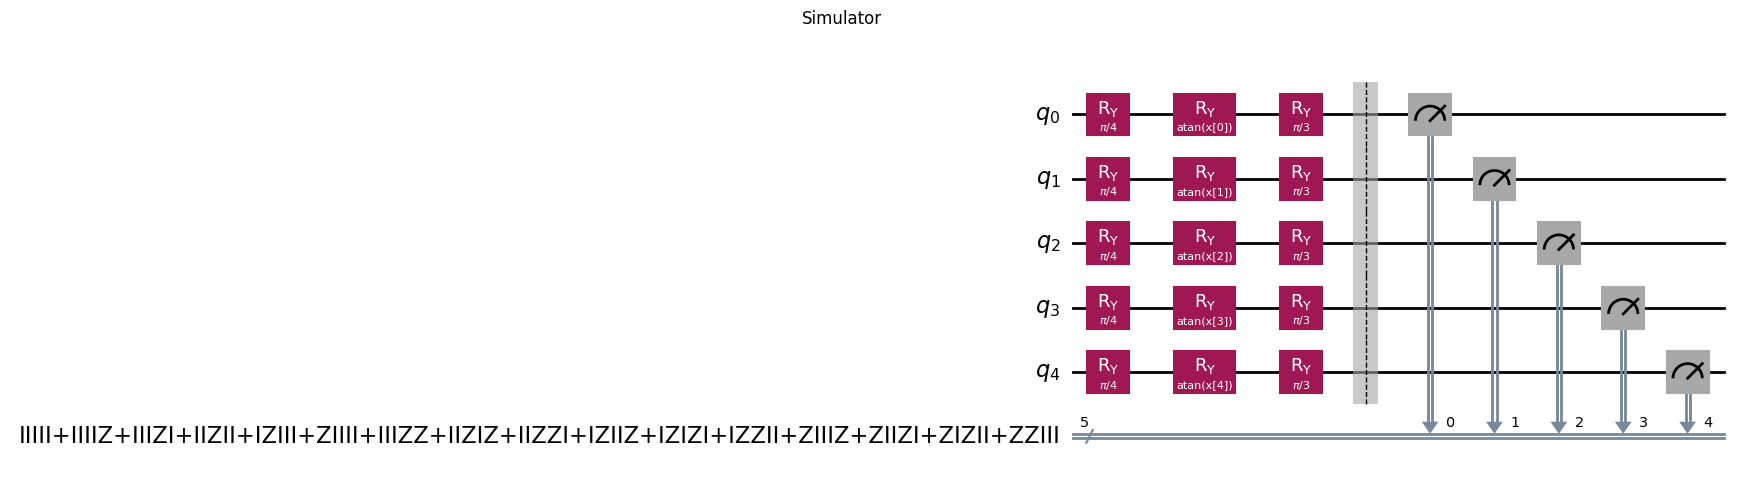

In [20]:
for measurement_circuit in get_measurement_circuits(
        encoding_circuit=encoding_circuit,
        observable=IsingHamiltonian(encoding_circuit.num_qubits),
        backend=None,
):
    measurement_circuit.draw("mpl").suptitle("Simulator")

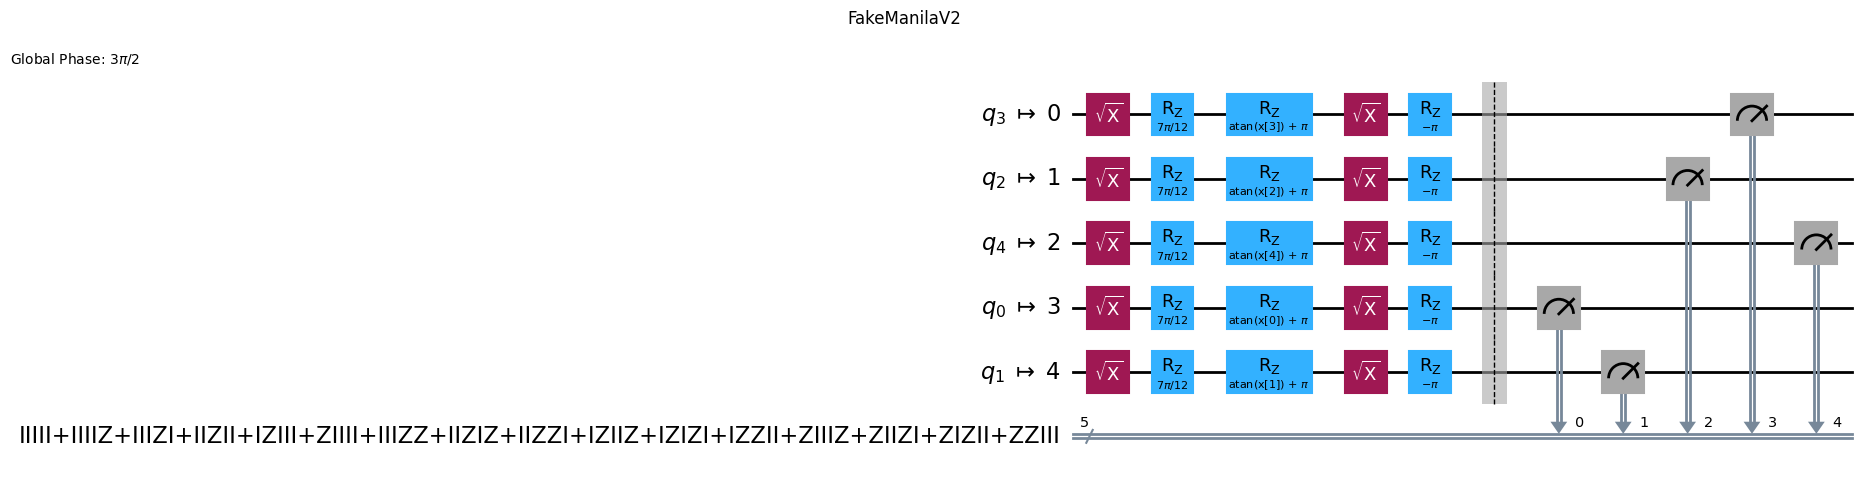

In [21]:
backend = FakeManilaV2()
for measurement_circuit in get_measurement_circuits(
        encoding_circuit=encoding_circuit,
        observable=IsingHamiltonian(encoding_circuit.num_qubits),
        backend=backend,
):
    measurement_circuit.draw("mpl").suptitle(backend.__class__.__name__)